# Generating synthetic tracking sequences from static images

##Introduction

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import IPython.display
import tracking.TrajectorySimulator
import animator

In order to generate a reasonable amount of training sequences to the tracking model, we plan to generate them artificially. The first approach leverages previously segmented objects from static images, and moves them over a background given by another image that mimics a scene. So, even though the simulated movements and segmented objects are limited, we may generate a large amount of simulations that may help the model infer complex types of motions in order to track arbitrary objects on an image sequence, with minimal human intervention to generate tracking ground truth information.

In [3]:
cocoFactory =  tracking.TrajectorySimulator.COCOSimulatorFactory('/home/datasets/datasets1/mscoco/','train2014')

!!!!!!!!!!!!! WARNING: Loading the COCO annotations can take up to 3 GB RAM !!!!!!!!!!!!!
loading annotations into memory...
Done (t=27.99s)
creating index...
index created!
Number of categories 80 and corresponding images 700
Category names: person, bicycle, car, motorcycle, airplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, sheep, cow, elephant, bear, zebra, giraffe, backpack, umbrella, handbag, tie, suitcase, frisbee, skis, snowboard, sports ball, kite, baseball bat, baseball glove, skateboard, surfboard, tennis racket, bottle, wine glass, cup, fork, knife, spoon, bowl, banana, apple, sandwich, orange, broccoli, carrot, hot dog, pizza, donut, cake, chair, couch, potted plant, bed, dining table, toilet, tv, laptop, mouse, remote, keyboard, cell phone, microwave, oven, toaster, sink, refrigerator, book, clock, vase, scissors, teddy bear, hair drier, toothbrush


In [13]:
reload(tracking.TrajectorySimulator)

<module 'tracking.TrajectorySimulator' from '/home/fmpaezri/repos/localization-agent/tracking/TrajectorySimulator.py'>

In [16]:
#simulator = cocoFactory.createInstance()
#simulator = tracking.TrajectorySimulator.TrajectorySimulator(scenePath, objPath, [], polygon=polygon, camSize=camSize, axes=True)
simulator = cocoFactory.create(\
                               '/home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000066299.jpg',\
                               '/home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000467579.jpg', axes=True)

Segmenting object from category potted plant
Trajectory: from 439 235 to 443 137
@TrajectorySimulator: New simulation with scene /home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000066299.jpg and object /home/datasets/datasets1/mscoco//images/train2014/COCO_train2014_000000467579.jpg


In [76]:
def show_axes():
    annotate('', xy=(0.4,0.9), xytext=(0.1,0.9), size=30, xycoords='axes fraction', textcoords='axes fraction', \
         arrowprops=dict(arrowstyle='simple', relpos=(0,0), fc=(1.0, 0.0, 0.0), ec=(1.0, 1.0, 0.0)))
    annotate('', xy=(0.1,0.6), xytext=(0.1,0.9), size=30, xycoords='axes fraction', textcoords='axes fraction', \
         arrowprops=dict(arrowstyle='simple', relpos=(0,0), fc=(0.0, 0.0, 1.0), ec=(1.0, 1.0, 0.0)))

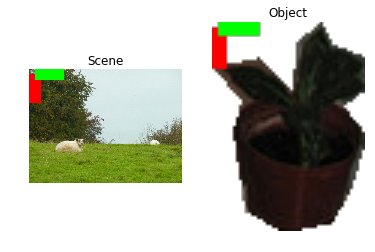

In [17]:
subplot(1,2,1)
axis('off')
imshow(asarray(simulator.scene))
title('Scene')
subplot(1,2,2)
axis('off')
imshow(asarray(simulator.obj))
title('Object')

##Modeling the sequence

The type of motions considered are those provided by general projective transformations, i.e. translation, rotation, scaling, shearing. By modeling movements as a succession of projective operations, we obtain a solid mathematical formulation of the motion. A planar projective transform from coordinate frame $a$ to $b$ is of the type
$$T_{a}^{b}=\begin{bmatrix} t_{1,1} & t_{1,2} & t_{1,3} \\ t_{2,1} & t_{2,2} & t_{2,3} \\ t_{3,1} & t_{3,2} & t_{3,3} \end{bmatrix}$$
where we are assuming use of homogeneous coordinates that allows handling rotations and translations under the same matrix-paradigm. The homogeneous coordinates are build by adding a third coordinate to the planar $x$ and $y$ coordinates, resulting in a new point $h$
$$h=\begin{bmatrix} x \\ y \\ z \end{bmatrix}$$

Using homogeneous coordinates, one can chain fine grained transformations into a complex single transformation. For example, the rotation by a $\theta$ angle, scaling by an $s$ factor and translation by $(t_{x}, t_{y})$ matrices are given by
$$R(\theta)_{a}^{b}=\begin{bmatrix} cos(\theta) & sin(\theta) & 0 \\ -sin(\theta) & cos(\theta) & 0 \\ 0 & 0 & 1 \end{bmatrix}$$
$$S(s)_{a}^{b}=\begin{bmatrix} s & 0 & 0 \\ 0 & s & 0 \\ 0 & 0 & 1 \end{bmatrix}$$
$$Tr(x,y)_{a}^{b}=\begin{bmatrix} 1 & 0 & t_{x} \\ 0 & 1 & t_{y} \\ 0 & 0 & 1 \end{bmatrix}$$

Which may be grouped in a single matrix T by multiplying on the desired order (as the transformations are not conmutative). For example, first rotating, then scaling and finally translating may be condensed as
$$T(x,y,s,̣\theta)=Tr(x,y)*S(s)*R(\theta)$$

A sequence may be described as an object moving over a scene viewed by a camera that also has its own motion. First lets think of the scene as a canvas were we are going to move the object, so we can create a coordinate system attached to the scene, which is going to be our absolute coordinate system. Then we apply a transformation $T_{object}(x,y,s,\theta)$ (as defined above) to the object in order to place it inside the scene, and we obtain a synthetic scene. Finally, to simulate camera movement we take a crop from the synthetic scene, but is taken after applying another transformation $T_{camera}(x,y,s,\theta)$ to the synthetic scene. This last transformation defines the point of view of the camera.

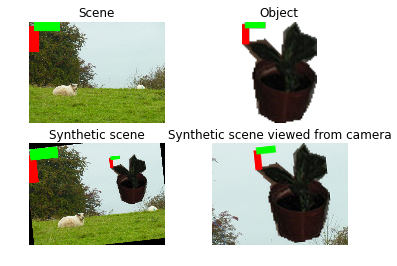

In [18]:
#Read a scene image and draw the CS
subplot(2,2,1)
axis('off')
imshow(asarray(simulator.scene))
title('Scene')
subplot(2,2,2)
axis('off')
imshow(asarray(simulator.obj))
title('Object')
subplot(2,2,3)
axis('off')
imshow(asarray(simulator.sceneView))
title('Synthetic scene')
subplot(2,2,4)
axis('off')
imshow(asarray(simulator.camView))
title('Synthetic scene viewed from camera')

In [19]:
output = '/tmp/simulation.mp4'

In [20]:
%time animator.frames2video(simulator, 30, output)

In [21]:
#videoSrc = 'http://storage.googleapis.com/www.thumos.info/thumos15_validation/thumos15_video_validation_0000001.mp4'
#For local files you could use the following instead
## WARNING: Be careful with too long videos, as this would take a lot of memory!!!!!!!!!
videoSrc = 'data:video/mp4;base64,' + open(output, 'rb').read().encode('base64')

In [22]:
videoTag = '<video controls><source src="{0}" type="video/mp4">Unsupported tag</video>'

In [23]:
IPython.display.HTML(videoTag.format(videoSrc))